<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Outlier_Analysis/01_Outlier_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outlier Identification

Ashley Dale

---

In this notebook you will learn the following concepts:
- How the refractive index of a material depends on its chemical composition
- The definition of an outlier
- The curse of dimensionality & basic dimensionality reduction
- How to calculate the Z-score for a data point
- Visualize outliers relative to the main distribution

#### Set up Python Environment

In [ ]:
%pip install ucimlrepo

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import pandas as pd
import copy

# Background Information

## Refractive Index and Chemical Composition

The refractive index $n$ is a characteristic number that describes the speed of light in a material:

<center>$n = \frac{speed\ of\ light\ in\ vacuum}{speed\ of\ light\ in\ material}$</center>

Exactly how to predict the refractive index of a material from its chemical formula is an [ongoing](https://www.sciencedirect.com/science/article/abs/pii/S0022369710001228) [area](https://www.mdpi.com/1420-3049/28/19/6805) of [research](https://ui.adsabs.harvard.edu/abs/2008OptCo.281.2132K/abstract) in materials science.

## Dataset: Glass Identification

The homepage for this dataset [can be found here](http://archive.ics.uci.edu/dataset/42/glass+identification), and was likely collected from an [experiment similar to this one](https://www.utsc.utoronto.ca/webapps/chemistryonline/production/refractive.php).  This dataset has three main pieces of information:

**Refractive Index (RI)**: the refractive index of each glass sample characterized for the dataset.

**Chemical Formula**: Eight elements (Na, Mg, Al, Si, K, Ca, Ba, and Fe) are mixed together in different ratios to make the different kinds of glass.  The fractional portion of each element is included as a column in the dataset.

**Type of Glass**: There are six different kinds of glass in the dataset:

|Class Index|Glass Type|
|---|---|
|1 | building windows (float processed) |
|2 | building windows (non-float processed) |
|3 | vehicle windows (float processed) |
|5 | containers |
|6 | tableware |
|7 | headlamps |

(Class #4 does not have any data in this dataset, so it is omitted.)

If we were interested in classifying the glass types based on their refractive index and chemical composition, this is what we would use as our target label.

Run the next cell to load the dataset and display the values:

In [ ]:
# load the dataset by running this cell
glass_identification = fetch_ucirepo(id=42)

# extract the refractive index and chemical formula information
raw_data = glass_identification.data.features
glass_kinds = glass_identification.data.targets

# show a Pandas Dataframe table of data in the notebook
raw_data

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0
...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0


- In the dataset above, there are nine columns, so there are nine features.

- We know from above that the RI value depends on the chemical formula.  We also know that the total fractional composition should add up to $\approx 1$.  This means that we cannot just change one number for a sample without affecting the others, and **the features are not independent**.  However, some features may be more dependent on (more correlated with) other features.  The idea of independent and dependent features is very important in data science. [Take a moment to watch this youtube video for more examples](https://www.youtube.com/watch?v=nkE1Ybap1N8).

---

Visualize the data using a [Seaborn pair plot](https://seaborn.pydata.org/generated/seaborn.pairplot.html) to find which features depend the most on each other:

1. Run the following cell to plot every feature against every other feature.  You should get a 9x9 grid of plots.

2. Look for the following things:

    - **Main Diagonal**: On the main diagonal, there are density plots that show the distribution of values for each feature.  Which values are spread out in a distribution, and which values are tightly centered around a single value?

    > IMPORTANT: If a feature has approximately the same value throughout the dataset, then this feature is likely to be independent.  It does not vary with another feature.

    - **Positive Correlations**: In the scatter plots that are above and below the main diagonal, identify a scatter plot that has a linear trend with a *positive* slope.  This indicates that the feature in the row and the feature in the column are positively correlated

    - **Negative Correlations**: In the scatter plots above and below the main diagonal, identify a scatter plot that has a linear trend with a *negative* slope.  This indicates that the feature in the row and the feature in the column are negatively correlated.

    - **Weak or No Correlations**: If a scatter plot does not have a linear trend, but instead forms a "blob", then the row feature and the column feature only weakly depend on each other, if they depend on each other at all.

    - **Noisy Data**: As you inspect the data, you might notice that some scatter plots are tightly clustered together with a few stray points, while other plots show a loose clustering.  Take a moment to identify which plots are noisier (more outliers) than others.

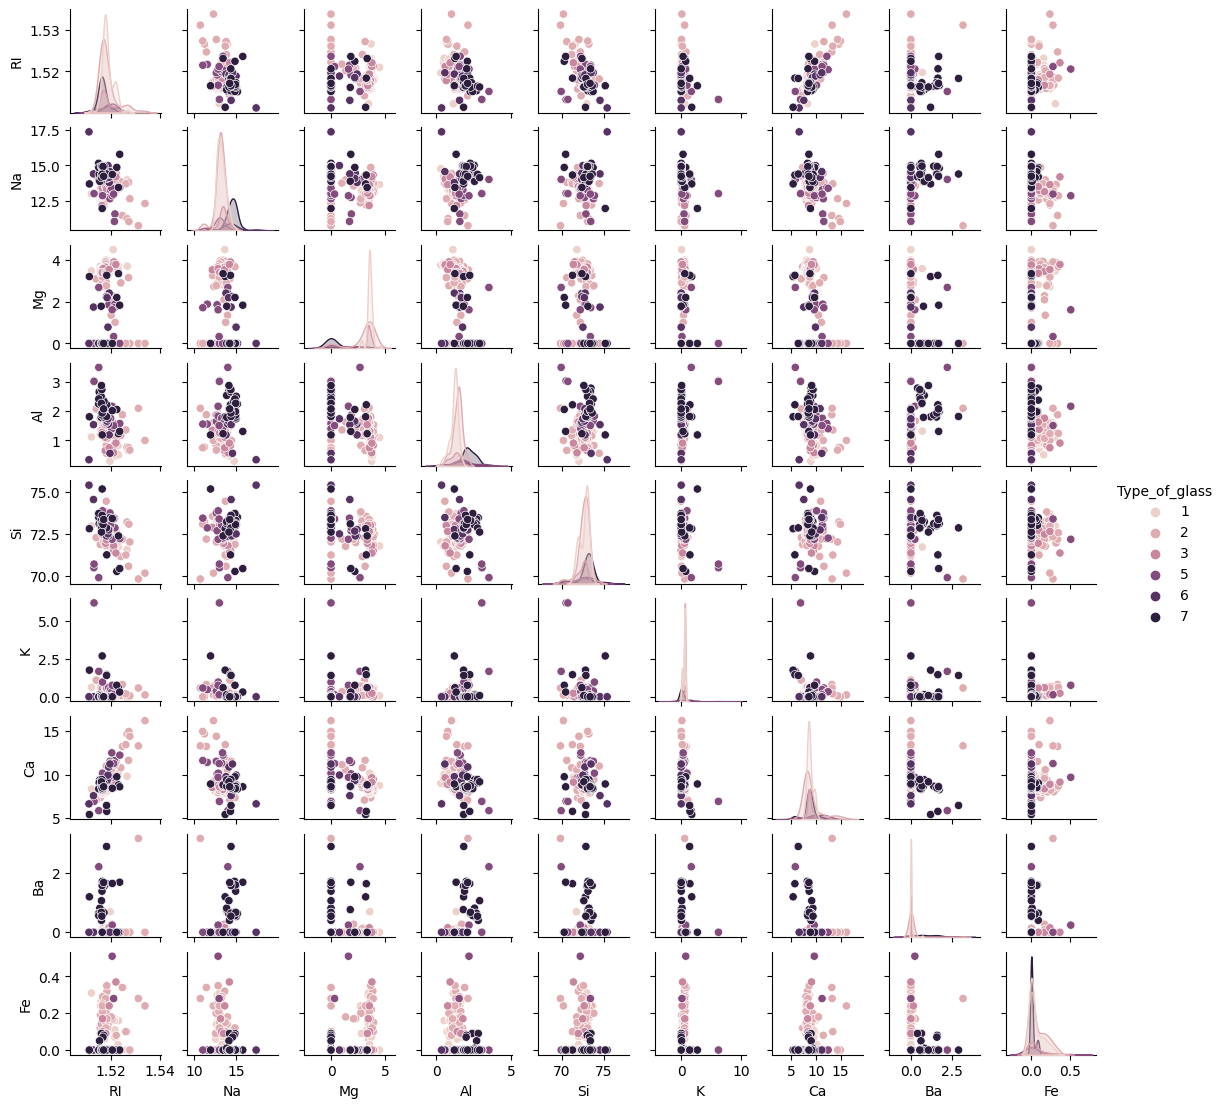

In [ ]:
sns.pairplot(pd.concat([raw_data, glass_kinds], axis=1), height=1.25, hue='Type_of_glass')

## Research Questions

We will use the data above to answer the following questions:

1. What element (or combination of elements) affects the RI value the most?
2. Are there any surprises (outliers) for how the chemical formula affects

To explore these questions efficiently, we will need the following ideas:

## Z-Score = Outlier or Not

A data point $x$ in a data set is an outlier *relative to the rest of the dataset* if the Z-score $|Z| \ge 3$.  The Z-score is calculated using the equation

<center>$Z = \frac{x - \mu}{\sigma}$</center>

where $\mu$ is the mean value of the dataset and $\sigma$ is the standard deviation of the dataset.  The standard deviation $\sigma$ is calculated:

<center>$\sigma = \sqrt{\frac{1}{N}\sum_i^N(x_i - \mu)}$</center>

where $N$ is the number of data points in the dataset, $x_i$ is the ith data point, and $\mu$ is the average value of all of the data points.  If $x$ is a vector $\vec{x}$, then $\vec{\mu}$, $\vec{\sigma}$, and $\vec{Z}$ are also vectors.

This is a very common statistical measure, also known as *standard score*.  You can read more about it [here](https://www.investopedia.com/terms/z/zscore.asp), [here](https://www.statisticshowto.com/probability-and-statistics/z-score/), and [here](https://en.wikipedia.org/wiki/Standard_score).  

The main idea is to use the standard deviation of the data as a unit of measurement. When $|Z| \ge 3$, the data point is three standard deviations away from the average value.

## Data Dimensionality and Dimensionality Reduction





### Data as a vector space

You might be familiar with thinking of data as a vector already.  Take for example the position vector:

<center>$\hat{r} = a \hat{i} + b \hat{j}$</center>

where $\hat{i}, \hat{j}$ are the unit vectors.  A single point in this space can be represented as $\hat{r} = [1.1, 0.7] = 1.1\hat{i} + 0.7\hat{j}$.  There are two independent dimensions.

Now remember the equation for projectile motion in one dimension:
<center>$y = y_o + v_ot + 0.5at^2$</center>

Here, we have five features: $y, y_o, v_o, a, t$. In this equation, the values for $y_o, v_o, a$ and $t$ can be changed without affecting the others: e.g. you can choose a new value for $a$ and have exactly the same $y_o$ value.  However, changing any of the $y_o, v_o, a$ or $t$ values will change the $y$ value. We call this equation "projectile motion in one dimension" because we have one dependent feature $y$; the equation space for the equation is much larger so we like to set everything except $t$ as a constant in the beginning. There are four independent features $y_o, v_o, a$ and $t$ and one dependent feature $y$, and only four unit vectors are needed even though the spreadsheet of data might have five columns.  

> If this feels strange to you, take a moment to think about the $\hat{r} = a\hat{i} + b\hat{j}$ equation again.  Even though we might have a table or spreadsheet that has three columns [r, x, y], we only have two unit vectors.  You can also [read more about a data science perspective of vectors here](https://neptune.ai/blog/understanding-vectors-from-a-machine-learning-perspective).

With complicated datasets, there may be several thousand features.  However, just because there are many features does not mean they are all independent.  In fact, it is usually safe to assume many are not and that you have no immediate method of figuring out which ones are independent.  

**High Dimensionality**

There is no hard and fast rule for knowing when you have "many" dimensions or "high" dimensional data, because it depends (in part) on how easy or hard it is to calculate something with many dimensions.  A good rule of thumb is that if you have at least 9 dimensions, you have high dimensional data.

### Curse of Dimensionality

This is a [mathematical phenomenon](https://en.wikipedia.org/wiki/Curse_of_dimensionality) where the more dimensions you have, the farther apart your data points become until every data point is equally far apart from every other data point.  Because there are more independent directions in which to move, data tends to spread out and un-clump.  Correlations disappear, there are fewer to no outlier data points, and [life becomes difficult for data scientists](https://builtin.com/data-science/curse-dimensionality).  

This problem is very common for high dimensional data when there are not enough data points. Specifically, if the dataset has $N$ features and $p$ data points, then $p>N$.  This is the same idea as solving a set of equations: there should be at least one independent equation for each unknown variable.  

### How to "Fix" High Dimensionality Data

For high-dimensional datasets where there are (presumably) many unknown dependent features, we can use some math tricks to do the following:

1. **Combine** dependent features with the independent feature they rely on to create new features.  This reduces the number of dimensions required for the dataset.  

2. **Ignore** features which are not "important", that is, not strongly correlated with the feature we might be interested in.

---

#### Methods for Dimensionality Reduction

Below is a list of common dimensionality reduction methods.  It is important to understand that there is no one "best" method.  Instead, make sure to research each method depending on your use case.  Some resources are linked below to get you started.

|Method Name|Main Idea|
|---|---|
|[Singular Value Decomposition (SVD)](https://machinelearningmastery.com/singular-value-decomposition-for-dimensionality-reduction-in-python/)|Use linear algebra to find a set of eigenvectors that define the space of the data, then keep only the eigenvectors with the largest eigenvalues|
|[Principle Component Analysis (PCA)](https://online.stat.psu.edu/stat508/lesson/6/6.2)|Almost the same as SVD, but instead of just finding the eigenvectors of the data space, choose eigenvectors in the direction *of the greatest variance in the data*.  [See this good link explaining the difference](https://safjan.com/what-is-the-key-difference-between-pca-and-svd/).|
|[Linear Discriminant Analysis (LDA)](https://www.analyticsvidhya.com/blog/2021/08/a-brief-introduction-to-linear-discriminant-analysis/)|Uses labeled data to help improve results by calculating the distance between points.|
|[T-Stochastic Neighbor Embedding (T-SNE)](https://www.datacamp.com/tutorial/introduction-t-sne)|Does not use eigenvectors, but can do a better job separating non-linear data.  Tries to find statistically significant data point neighbors|
|[Uniform Manifold Approximation and Projection (UMAP)](https://pair-code.github.io/understanding-umap/)|Similar to T-SNE, but makes different mathematical assumptions|

---

In the next programming exercise, we will use PCA for the following reasons:

1. We want to identify outliers for our data set by calculating a Z-score.  Since we know that we have high-dimensional data with dependent features, we can use PCA to reduce the dimensionality to find independent features.  We can then calculate the Z-score on the reduced-dimensionality data more easily and more meaningfully.

2. Since PCA uses a coordinate system based on the direction of most variance, and the Z-score relies on the standard deviation which comes from the data variance, this method of dimensionality reduction lets us calculate the Z-score along the direction of most variance.  This increases the likeliness that we will correctly identify outliers.

# Exercises

## Programming Exercise 1: Dimensionality Reduction

For this exercise we will use the PCA implementation from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).  

In [ ]:
# The first thing we must do is decide how many component features we want
# the PCA algorithm to return to us

# Fill in the next line with the number of components you are
# interested in exploring.  To make life easy on yourself, choose
# 1, 2, or 3.  However, if you are bold (and ready to do some debugging),
# you can choose up to 9 because that is the original number of features
# in our dataset

n_components =

## adding this line to convert the data from a Pandas data frame to an np.array
data = np.array(copy.deepcopy(raw_data))

In [ ]:
# Uncomment the next line to create a PCA algorithm object
#pca = PCA(n_components)

In [ ]:
# Next, we can apply the algorithm to our data:
pca.fit(data)

PCA(n_components=2)

In [ ]:
# Finally, we can transform the data by projecting it
# into the new coordinate system

transformed_data = pca.transform(data)

Double check that the data has been transformed by printing the shape of the original `data` array and the shape of the `transformed_data` array.  The first one is done for you.  You can also check the documentation for `np.shape()` [here](https://numpy.org/doc/stable/reference/generated/numpy.shape.html).

In [ ]:
print('Original Data Shape: ', np.shape(data))

## Add the second print statement below:



Original Data Shape:  (214, 9)
Transformed Data Shape:  (214, 2)


The print statements should show that the first number in the shape is 214, the number of rows and also the number of data points in the dataset.  The second number should be the columns: 9 for the original data and 2 for the transformed data.

Finally, we want to check how good of a job the PCA algorithm did finding a coordinate system that lined up with the data variance.  We can do that by asking the algorithm to report the `explained_variance_ratio_`.  The `explained_variance_ratio_` will say that $P_1\%$ of the variance is along the direction of new PCA feature $p_1$, $P_2\%$ is explained by PCA feature $p_2$, and so on.

In [ ]:
print('Variance Explained: ', pca.explained_variance_ratio_)
print('Sum of Explained Variances: ', np.sum(pca.explained_variance_ratio_))

Variance Explained:  [0.47620525 0.26319276]
Sum of Explained Variances:  0.7393980075221334


## Programming Exercise 2: Calculate Z-score

Now implement the Z-score calculation for each column of the transformed data using the equation

<center>$Z = \frac{x - \mu}{\sigma}$</center>

---
Some helpful `numpy` functions might be:

[`np.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html): returns the average value along an array axis.  

[`np.std()`](https://numpy.org/doc/stable/reference/generated/numpy.std.html): returns the standard deviation along an array axis.

> If axis=0, it is the calculating along the rows, and if axis=1, the calculation is along the columns.  

In [ ]:
# Z calculation for the first column is done for you
Z1 = (transformed_data[:, 0] - np.mean(transformed_data[:, 0]))/(np.std(transformed_data[:, 0]))

# Complete the calculation for the second column
Z2 =

Let's do a check to see if we have any outliers.  Copy paste the following statement into the code cell below and run:

`print('Outliers Found') if (np.abs(Z1)>3).any else print('No Outliers')`


In [ ]:
## Copy paste code here:



Outliers Found


Next, we want to know what data points are outliers.  To do this, we want the indices where $(Z_1, Z_2) > 3$.  Copy paste the following statement into the code cell below and run:
`outlier_idx = np.where(np.abs(Z1)>3)[0]`



In [ ]:
outlier_idx =
print('The following data points are outliers: ', outlier_idx)

The following data points are outliers:  [107 110 111 112]


Finally,  we want to know what kind of glass the outliers are.  

|Class Index|Glass Type|
|---|---|
|1 | building windows (float processed) |
|2 | building windows (non-float processed) |
|3 | vehicle windows (float processed) |
|5 | containers |
|6 | tableware |
|7 | headlamps |

Uncomment the following code into the cell and run:

In [ ]:
# label_dict = {1: 'building windows (float process)',
#               2: 'building windows (non-float process)',
#               3: 'vehicle windows (float processed)',
#               5: 'containers',
#               6: 'tableware',
#               7: 'headlamps'}

# outlier_labels = [np.array(glass_kinds)[i][0] for i in outlier_idx]

# for ol, pt in zip(outlier_labels, outlier_idx):
#     result_string = 'Point '+str(pt)+': '+label_dict[ol]
#     print(result_string)

Point 107: building windows (non-float process)
Point 110: building windows (non-float process)
Point 111: building windows (non-float process)
Point 112: building windows (non-float process)


## Programming Exercise 3: Visualize Results

Finally, let's plot the results in two figures.

Figure 1: Plot the distributions of the Z scores as a histogram. [See here for a tutorial on how to plot different histogram styles](https://matplotlib.org/stable/gallery/statistics/histogram_multihist.html#sphx-glr-gallery-statistics-histogram-multihist-py).

Figure 2: Plot the transformed data.  Use the Z scores as a color map; [see how to do this here](https://www.statology.org/matplotlib-scatterplot-color-by-value/).  Also experiment with using the glass type labels as a color map.

Make sure to include axis labels and plot titles for each figures.  Use a [matplotlib legend](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html) if appropriate.

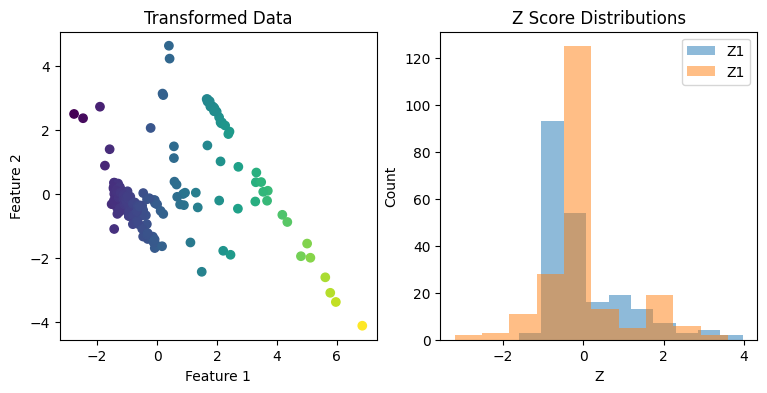

In [ ]:
### Add your plotting code here

## Bonus Problem: Implement LDA Dimensionality Reduction

Repeat the code above, but now use Linear Discriminant Analysis to perform the dimensionality reduction.  Plot the results a second time, and discuss the differences.

The documentation for LDA [can be found here](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

In [ ]:
# Insert your solution here

## Answer These Questions:

*Note to Instructor: Example answers are provided.  Students may offer additional correct answers*

1. In the pair-wise plot above, which features did you find that were positively correlated?

> **Answer**:

2. In the pair-wise plot above, which features did you find that were negatively correlated?

>**Answer**:

3. In the pair-wise plot above, which features were independent with a constant value?

>**Answer**:

4. In the expression $v = v_o + at$, which features are independent, and which are dependent?  What dimensionality of data would you have?

>**Answer**:  

# Additional Readings
1. [NIST Guide to Outlier Detection](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm)
1. [Dimensionality Reduction in Machine Learning Overview](https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/)